# Algorithmic Trading Model for Trend-Following with MACD Indicator Strategy Using Python Take 1
### David Lowe
### March 15, 2021

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model examines a simple trend-following strategy for a stock. The model enters a position when the price reaches either the highest or the lowest points for the last X number of days. The model will exit the trade when the stock's MACD histogram switches side.

In addition to the stock price, the models will also use the trading volume indicator to confirm the buy/sell signal further. Finally, the strategy will also incorporate a profit/loss threshold. The strategy will exit the position when the profit or the loss has reached the threshold.

In this Take1 iteration, we will set up the models using a trend window size for long trades only. The window size will vary from 10 to 20 trading days at a 5-day increment. We will use 10 to 20 days for the fast EMA curve and 40 to 50 days for the slow EMA curve. The models will also incorporate a volume indicator with a fixed window size of 10 days to confirm the buy/sell signal. Furthermore, we will establish a profit threshold of 15% and a loss threshold of 8%.

ANALYSIS: In this Take1 iteration, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2018, and March 12, 2021. The top trading model produced a profit of 56.72 dollars per share. The buy-and-hold approach yielded a gain of 77.86 dollars per share.

CONCLUSION: For the stock of AAPL during the modeling time frame, the long trading strategy with profit/loss limits did not produce a better return than the buy-and-hold approach. We should consider modeling this stock further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
#
# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Retrieve the CPU information
# ncpu = !nproc
# print("The number of available CPUs is:", ncpu[0])

### 1.a) Load libraries and modules

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv
# import pandas_datareader.data as pdr

# Begin the timer for the script processing
startTimeScript = datetime.now()

### 1.b) Set up the controlling parameters and functions¶

In [6]:
# Specify the key modeling parameters below
STOCK_SYMBOL = 'AAPL'
INITIAL_CAPITAL = 0

# Specify the moving average parameters for the trading strategy
WINDOW_MIN = 10
WINDOW_MAX = 20
WINDOW_INCREMENT = 5
VOL_MA_MIN = 10
VOL_MA_MAX = 10
VOL_MA_INCREMENT = 10
HOLDING_MIN = 999
HOLDING_MAX = 999
HOLDING_INCREMENT = 10
GAIN_MAX = 0.15
LOSS_MAX = 0.08
FAST_MA_MIN = 10
FAST_MA_MAX = 20
SLOW_MA_MIN = 40
SLOW_MA_MAX = 50
MA_INCREMENT = 5
MA_GAP = 10

LONG_ONLY = True
SHORT_ONLY = False
if LONG_ONLY and SHORT_ONLY: sys.exit("Cannot have both LONG_ONLY and SHORT_LONG flags be set to True. Script Processing Aborted!!!")

# The number of extra days of data we need for calculating moving averages (usually equals to the largest value of slow MA)
EXTRA_DAYS = SLOW_MA_MAX

MODEL_START_DATE = date(2018, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2021, 3, 12)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = MODEL_START_DATE
data_start_date = MODEL_START_DATE - timedelta(days=int(EXTRA_DAYS * 1.5)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

Starting date for the model: 2018-01-01
Ending date for the model: 2021-03-12
First date of data we need for modeling: 2017-10-18
Last date of data we need for modeling: 2021-03-12


In [7]:
# Specify the script running parameters below

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 384)

# Configure the plotting style
plt.style.use('seaborn')

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_signals = False
verbose_models = False
verbose_graphs = False
verbose_trade_actions = False
verbose_portfolios = False
verbose_transactions = False
verbose_positions = False

In [8]:
# Set up the parent directory location for loading the dotenv files

# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up access to the dotenv file on local PC
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

## Task 2 - Acquire and Pre-Process Data

In [9]:
# Set up the data service provider and data acquisition parameters
data_service = 'Quandl'

# Check and see whether the API key is available
api_key = os.environ.get('QUANDL_API')
if api_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

start_date_string = data_start_date.strftime('%Y-%m-%d')
end_date_string = data_end_date.strftime('%Y-%m-%d')
api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s&qopts.data_version=2" % (start_date_string, end_date_string, STOCK_SYMBOL, api_key)
response = requests.get(api_url)
resp_dict = json.loads(response.text)
stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
print(len(stock_rawdata), 'data points retrieved from the API call.')

855 data points retrieved from the API call.


In [10]:
stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'closeadj', 'closeunadj', 'lastupdated']
# stock_rawdata.set_index('date', inplace=True)
stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
stock_pricing = stock_rawdata.sort_index(ascending=True)
print(stock_pricing.head())
print()
print(stock_pricing.tail())

           ticker        date    open    high     low   close       volume  closeadj  closeunadj lastupdated
date                                                                                                        
2017-10-18   AAPL  2017-10-18  40.105  40.178  39.900  39.940   65496656.0    38.238      159.76  2021-02-05
2017-10-19   AAPL  2017-10-19  39.188  39.270  38.755  38.995  170336664.0    37.333      155.98  2021-02-05
2017-10-20   AAPL  2017-10-20  39.153  39.438  38.990  39.062   95896584.0    37.397      156.25  2021-02-05
2017-10-23   AAPL  2017-10-23  39.222  39.422  38.875  39.042   87937308.0    37.378      156.17  2021-02-05
2017-10-24   AAPL  2017-10-24  39.072  39.355  39.050  39.275   71028920.0    37.601      157.10  2021-02-05

           ticker        date    open    high     low    close       volume  closeadj  closeunadj lastupdated
date                                                                                                         
2021-03-08   AAP

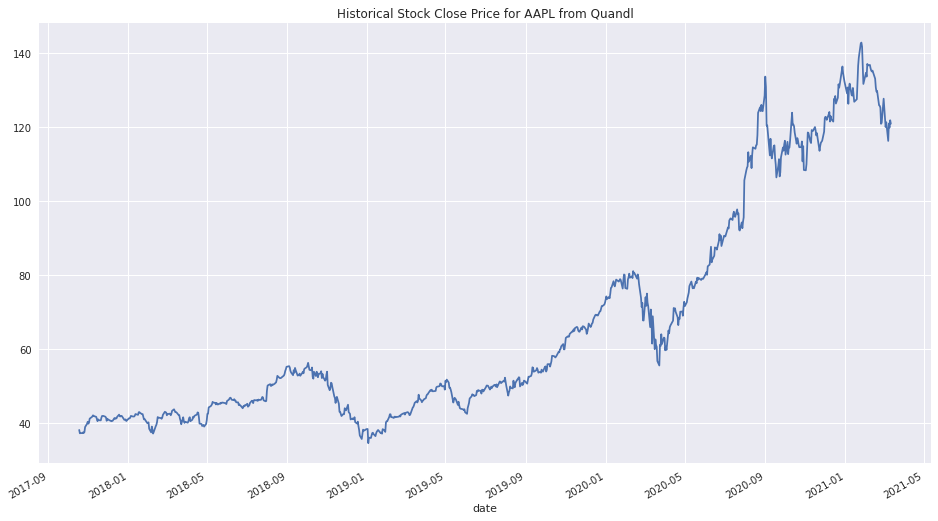

In [11]:
# Set up the standard column name for modeling
# Column names may be data-provider specific!
MODEL_TEMPLATE = stock_pricing.loc[:, ['open','closeadj','volume']]
MODEL_TEMPLATE.rename(columns={'open': 'open_price', 'closeadj': 'close_price', 'volume': 'trading_volume'}, inplace=True)
plot_title = 'Historical Stock Close Price for ' + STOCK_SYMBOL + ' from ' + data_service
MODEL_TEMPLATE['close_price'].plot(figsize=(16,9), title=plot_title)
plt.show()

## Task 3 - Implement and Train Models

In [12]:
# Define the function that will generate the indicators and trading signals
# General logic for processing the trading signals for each time period
# 1 - Check to see whether we need to execute a trading action from the previous day's signal. Once the trading action is executed, move on to the next day.
# 2 - If no trade actions to execute on open, check to see whether we have any breakout that generates a trading signal. If we have a new trading signal and currently has no position, mark the entry action for the next day.
# 3 - If no new signal for today, check to see whether we need to exit any existing position. If we have an exit signal and currently hold a position, mark the exit action for the next day.
# 4 - If nothing is going on, mark up the trading model appropriately and move to the next day.

def populate_signals(window=WINDOW_MIN, vol_ma=VOL_MA_MIN, max_holding=HOLDING_MAX, fast_ma=FAST_MA_MIN, slow_ma=SLOW_MA_MIN):

    trade_model = MODEL_TEMPLATE.copy()
    trade_model['window_high'] = trade_model['close_price'].shift(1).rolling(window=window).max()
    trade_model['window_low'] = trade_model['close_price'].shift(1).rolling(window=window).min()
    trade_model['buy_on_open'] = False
    trade_model['sell_on_open'] = False
    trade_model['short_on_open'] = False
    trade_model['cover_on_open'] = False
    trade_model['holding_period'] = None
    trade_model['cost_basis'] = None
    trade_model['pandl_pct'] = None
    trade_model['position_long'] = None
    trade_model['position_short'] = None
    trade_model['window_avg'] = trade_model['close_price'].shift(1).rolling(window=window).mean()
    trade_model['close_above_avg'] = False  # Price closes above the window average
    trade_model['close_below_avg'] = False  # Price closes below the window average
    trade_model['volume_ma'] = trade_model['trading_volume'].rolling(vol_ma).mean()
    trade_model['ema_fast'] = trade_model['close_price'].ewm(span=fast_ma).mean()
    trade_model['ema_slow'] = trade_model['close_price'].ewm(span=slow_ma).mean()
    trade_model['ema_change'] = trade_model['ema_fast'] - trade_model['ema_slow']
    trade_model['macd_signal'] = trade_model['ema_change'].ewm(span=((slow_ma+fast_ma)/2)).mean()
    trade_model['macd_hist'] = trade_model['ema_change'] - trade_model['macd_signal']

    # Truncate the model to the required starting and ending dates
    trade_model = trade_model[MODEL_START_DATE:MODEL_END_DATE]
    last_index = len(trade_model) - 1

    for k in range(len(trade_model)):
        breakout_high = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_high']
        breakout_low = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_low']
        trade_volume = trade_model.at[trade_model.index[k],'trading_volume']
        average_volume = trade_model.at[trade_model.index[k],'volume_ma']
        if k == 0:
            currently_long = False
            currently_short = False
            holding_period = 0
            cost_basis = 0
        else:
            currently_long = trade_model.at[trade_model.index[k-1],'position_long']
            currently_short = trade_model.at[trade_model.index[k-1],'position_short']
            holding_period = trade_model.at[trade_model.index[k-1],'holding_period']
            cost_basis = trade_model.at[trade_model.index[k-1],'cost_basis']

        trade_executed_today = False

        # Check to see whether we need to execute any trade action on open
        if trade_model.at[trade_model.index[k],'buy_on_open']:
            trade_executed_today = True
            currently_long = True
            currently_short = False
            holding_period = 1
            cost_basis = -trade_model.at[trade_model.index[k],'open_price']
        elif trade_model.at[trade_model.index[k],'short_on_open']:
            trade_executed_today = True
            currently_long = False
            currently_short = True
            holding_period = 1
            cost_basis = trade_model.at[trade_model.index[k],'open_price']
        elif trade_model.at[trade_model.index[k],'sell_on_open']:
            trade_executed_today = True
            currently_long = False
            currently_short = False
            holding_period = 0
            cost_basis = 0.0
        elif trade_model.at[trade_model.index[k],'cover_on_open']:
            trade_executed_today = True
            currently_long = False
            currently_short = False
            holding_period = 0
            cost_basis = 0.0
        else:
            # If no trade on open, check to see whether we have a breakout with an entry the next day
            if (breakout_high >= 0) and (not currently_long) and (not currently_short) and (trade_volume > average_volume) and (k < last_index-1) and (not SHORT_ONLY):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif (breakout_low < 0) and (not currently_long) and (not currently_short) and (trade_volume > average_volume) and (k < last_index-1) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True
            else:
                # If no breakout, check to see whether we need to exit an existing position the next day
                if currently_short and (k < last_index-1):
                    if ((trade_model.at[trade_model.index[k-1],'macd_hist'] < 0) and (trade_model.at[trade_model.index[k],'macd_hist'] > 0)) or (holding_period+1 >= max_holding):
                        trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
                elif currently_long and (k < last_index-1):
                    if ((trade_model.at[trade_model.index[k-1],'macd_hist'] > 0) and (trade_model.at[trade_model.index[k],'macd_hist'] < 0)) or (holding_period+1 >= max_holding):
                        trade_model.at[trade_model.index[k+1],'sell_on_open'] = True

        # If no action on a given day, carry over the position status
        if (k > 0) and (not trade_executed_today):
            if currently_long or currently_short:
                holding_period = holding_period + 1

        trade_model.at[trade_model.index[k],'position_long'] = currently_long
        trade_model.at[trade_model.index[k],'position_short'] = currently_short
        trade_model.at[trade_model.index[k],'holding_period'] = holding_period
        trade_model.at[trade_model.index[k],'cost_basis'] = cost_basis

        # Check to see whether the profit or loss target has been met for exiting the position
        if currently_long :
            pandl_pct = (cost_basis + trade_model.at[trade_model.index[k],'close_price']) / abs(cost_basis)
            trade_model.at[trade_model.index[k],'pandl_pct'] = pandl_pct
            if (pandl_pct >= GAIN_MAX) or (pandl_pct <= -LOSS_MAX) :
                trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
        elif currently_short :
            pandl_pct = (cost_basis - trade_model.at[trade_model.index[k],'close_price']) / abs(cost_basis)
            trade_model.at[trade_model.index[k],'pandl_pct'] = pandl_pct
            if (pandl_pct >= GAIN_MAX) or (pandl_pct <= -LOSS_MAX) :
                trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
        else:
            trade_model.at[trade_model.index[k],'pandl_pct'] = 0.0

        # # Exiting the position on the last day of modeling period
        # if k == last_index-1:
        #     if trade_model.at[trade_model.index[k],'position_long']:
        #         trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
        #         trade_model.at[trade_model.index[k+1],'position_long'] = False
        #     elif trade_model.at[trade_model.index[k],'position_short']:
        #         trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
        #         trade_model.at[trade_model.index[k+1],'position_short'] = False

    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [13]:
# Build the collection of trading models by iterating through the parameters
trading_model_collection = {}
serial_no = 0
for window_size in range(WINDOW_MIN, WINDOW_MAX+1, WINDOW_INCREMENT):
    for vol_average in range(VOL_MA_MIN, VOL_MA_MAX+1, VOL_MA_INCREMENT):
        for hold_period in range(HOLDING_MIN, HOLDING_MAX+1, HOLDING_INCREMENT):
            for fastma_curve in range(FAST_MA_MIN, FAST_MA_MAX+1, MA_INCREMENT):
                for slowma_curve in range(SLOW_MA_MIN, SLOW_MA_MAX+1, MA_INCREMENT):
                    if (slowma_curve - fastma_curve) < MA_GAP: break
                    serial_no += 1
                    model_tag = 'Model_' + str(serial_no).zfill(3) + '_WINDOW_' + str(window_size).zfill(3) + '_FASTMA_' + str(fastma_curve).zfill(3) + '_SLOWMA_' + str(slowma_curve).zfill(3) + '_VOLMA_' + str(vol_average).zfill(3) + '_HOLD_' + str(hold_period).zfill(3)
                    if verbose_signals: print('Processing model:', model_tag)
                    trading_model = populate_signals(window_size, vol_average, hold_period, fastma_curve, slowma_curve)
                    trading_model_collection[model_tag] = trading_model.copy()
print(len(trading_model_collection), 'trading models generated!')

27 trading models generated!


In [14]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print(trade_model[trade_model['buy_on_open'] | trade_model['sell_on_open'] | trade_model['short_on_open'] | trade_model['cover_on_open']])

In [15]:
if verbose_models:
    for model_name in trading_model_collection:
        print('List the signal changes and entry/exit points for model:', model_name)
        list_model_entry_exit(trading_model_collection[model_name])
        print()

In [16]:
def draw_model_graph(trade_model, mdl_name=STOCK_SYMBOL):
    graph_data = trade_model.copy()
    title_string = 'Simple Trend-Following Trading Model for ' + mdl_name
    fig = plt.figure(figsize=(16,9))
    ylabel = STOCK_SYMBOL + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data['ema_fast'].plot(ax=ax1, color='r')
    graph_data['ema_slow'].plot(ax=ax1, color='b')
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data['buy_on_open']].index, graph_data.close_price[graph_data['buy_on_open']], '^', markersize=7, color='b',label='Buy on Open')
    ax1.plot(graph_data.loc[graph_data['sell_on_open']].index, graph_data.close_price[graph_data['sell_on_open']], 'v', markersize=7, color='b',label='Sell on Open')
    ax1.plot(graph_data.loc[graph_data['short_on_open']].index, graph_data.close_price[graph_data['short_on_open']], '^', markersize=7, color='r',label='Short on Open')
    ax1.plot(graph_data.loc[graph_data['cover_on_open']].index, graph_data.close_price[graph_data['cover_on_open']], 'v', markersize=7, color='r',label='Cover on Open')
    plt.legend(loc='upper left')
    plt.show()

In [17]:
if verbose_graphs:
    for model_name in trading_model_collection:
        draw_model_graph(trading_model_collection[model_name], model_name)

## Task 4 - Back-test Models

In [18]:
def generate_trading_portfolios(trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'price_executed', 'qty_transacted', 'cost_basis', 'gain_loss', 'qty_on_hand', 'cash_on_hand', 'position_value', 'total_position', 'accum_return'])
    portfolio['trade_action'] = False
    portfolio.at[portfolio.index[0],'price_executed'] = 0.00
    portfolio.at[portfolio.index[0],'qty_transacted'] = 0
    portfolio.at[portfolio.index[0],'cost_basis'] = 0.00
    portfolio.at[portfolio.index[0],'gain_loss'] = 0.00
    portfolio.at[portfolio.index[0],'qty_on_hand'] = 0
    portfolio.at[portfolio.index[0],'cash_on_hand'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'position_value'] = 0.00
    portfolio.at[portfolio.index[0],'total_position'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'accum_return'] = 0.00
    quantity = 1

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        price_per_share = trade_model.at[trade_model.index[i],'open_price']
        if trade_model.at[trade_model.index[i],'buy_on_open']:
            # Code block for Buy on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = price_per_share * -quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('BOUGHT QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'sell_on_open']:
            # Code block for Sell on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = (price_per_share * quantity) + portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + (price_per_share * quantity)
            if verbose_trade_actions: print('SOLD QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'short_on_open']:
            # Code block for Short on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = price_per_share * quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('SHORTED QTY:', -quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        elif trade_model.at[trade_model.index[i],'cover_on_open']:
            # Code block for Cover on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = portfolio.iloc[i-1]['cost_basis'] - (price_per_share * quantity)
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] - (price_per_share * quantity)
            if verbose_trade_actions: print('COVERED QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        else:
            # Code block for no trade actions
            portfolio.at[portfolio.index[i],'price_executed'] = 0.00
            portfolio.at[portfolio.index[i],'qty_transacted'] = 0
            portfolio.at[portfolio.index[i],'cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand']
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand']
        portfolio.at[portfolio.index[i],'position_value'] = trade_model.at[trade_model.index[i],'close_price'] * portfolio.at[portfolio.index[i],'qty_on_hand']
        portfolio.at[portfolio.index[i],'total_position'] = portfolio.at[portfolio.index[i],'cash_on_hand'] + portfolio.at[portfolio.index[i],'position_value']
        portfolio.at[portfolio.index[i],'accum_return'] = portfolio.at[portfolio.index[i],'total_position'] - INITIAL_CAPITAL

    if verbose_portfolios: print('\n', portfolio, '\n')
    return portfolio

In [19]:
def calculate_positions_and_performance(trade_model):
    trade_positions = generate_trading_portfolios(trade_model)
    trade_transactions = trade_positions[trade_positions['trade_action']]
    if verbose_transactions: print(trade_transactions)
    if trade_transactions.at[trade_transactions.index[-1],'trade_action']:
        if trade_transactions.at[trade_transactions.index[-1],'qty_on_hand'] == 0:
            print('The current status of the model is:','Waiting to enter a position since',trade_transactions.index.tolist()[-1].date(),'\n')
        elif trade_transactions.at[trade_transactions.index[-1],'qty_on_hand'] > 0:
            print('The current status of the model is:','Holding a long position since',trade_transactions.index.tolist()[-1].date(),'\n')
        else:
            print('The current status of the model is:','Holding a short position since',trade_transactions.index.tolist()[-1].date(),'\n')
    return trade_positions

In [20]:
# Convert trading models into positions and calculate profit and loss
# Initialize a dictionary for tracking positions for all models
model_positions_collection={}

for model_name in trading_model_collection:
    print('Processing the positions for model:', model_name)
    model_positions_collection[model_name] = calculate_positions_and_performance(trading_model_collection[model_name])
print(len(model_positions_collection), 'sets of model positions generated.')

Processing the positions for model: Model_001_WINDOW_010_FASTMA_010_SLOWMA_040_VOLMA_010_HOLD_999
The current status of the model is: Waiting to enter a position since 2021-02-03 

Processing the positions for model: Model_002_WINDOW_010_FASTMA_010_SLOWMA_045_VOLMA_010_HOLD_999
The current status of the model is: Waiting to enter a position since 2021-02-04 

Processing the positions for model: Model_003_WINDOW_010_FASTMA_010_SLOWMA_050_VOLMA_010_HOLD_999
The current status of the model is: Waiting to enter a position since 2021-02-04 

Processing the positions for model: Model_004_WINDOW_010_FASTMA_015_SLOWMA_040_VOLMA_010_HOLD_999
The current status of the model is: Waiting to enter a position since 2021-02-04 

Processing the positions for model: Model_005_WINDOW_010_FASTMA_015_SLOWMA_045_VOLMA_010_HOLD_999
The current status of the model is: Waiting to enter a position since 2021-02-08 

Processing the positions for model: Model_006_WINDOW_010_FASTMA_015_SLOWMA_050_VOLMA_010_HOLD_9

In [21]:
# Initialize a dataframe for storing the model's profit and loss
model_performance_summary = pd.DataFrame(columns=['Model_name','Return_value','Return_percentage'])
for model_name in model_positions_collection:
    if verbose_positions: print('Processing positions for model:', model_name)
    if verbose_positions: print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model_positions_collection[model_name].accum_return[-1]))
    if INITIAL_CAPITAL != 0:
        return_percentage = model_positions_collection[model_name].accum_return[-1] / INITIAL_CAPITAL * 100
        if verbose_positions: print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
    else:
        return_percentage = None
    if verbose_positions: print()
    model_performance_summary = model_performance_summary.append({'Model_name': model_name, 'Return_value': model_positions_collection[model_name].accum_return[-1], 'Return_percentage': return_percentage}, ignore_index=True)
    model_performance_summary.sort_values(by=['Return_value'], inplace=True, ascending=False)

print(len(model_performance_summary), 'profit/loss summaries generated.\n')
print('The top ten model\'s performance summary:')
print(model_performance_summary.head(10))

27 profit/loss summaries generated.

The top ten model's performance summary:
                                          Model_name  Return_value Return_percentage
0  Model_001_WINDOW_010_FASTMA_010_SLOWMA_040_VOL...        56.725              None
1  Model_010_WINDOW_015_FASTMA_010_SLOWMA_040_VOL...        56.725              None
2  Model_018_WINDOW_015_FASTMA_020_SLOWMA_050_VOL...        53.353              None
3  Model_009_WINDOW_010_FASTMA_020_SLOWMA_050_VOL...        53.353              None
4  Model_002_WINDOW_010_FASTMA_010_SLOWMA_045_VOL...        53.169              None
5  Model_011_WINDOW_015_FASTMA_010_SLOWMA_045_VOL...        53.169              None
6  Model_006_WINDOW_010_FASTMA_015_SLOWMA_050_VOL...        53.147              None
7  Model_015_WINDOW_015_FASTMA_015_SLOWMA_050_VOL...        53.147              None
8  Model_008_WINDOW_010_FASTMA_020_SLOWMA_045_VOL...        52.469              None
9  Model_017_WINDOW_015_FASTMA_020_SLOWMA_045_VOL...        52.469      

## Task 5 - Evaluate Strategy Performance

In [22]:
# Calculate the stock's performance for a buy-and-hold model
top_model_name = model_performance_summary.loc[0]['Model_name']
top_trading_model = trading_model_collection[top_model_name]
print('The entry point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[0]['open_price'], top_trading_model.index[0].date()))
print('The exit point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[-1]['open_price'], top_trading_model.index[-1].date()))
print('The performance of the buy-and-hold model: $%.2f' %(top_trading_model.iloc[-1]['open_price'] - top_trading_model.iloc[0]['open_price']))
print('The performance of the top trading model: $%.2f' %(model_performance_summary.iloc[0]['Return_value']))

The entry point for the buy-and-hold model: $42.54 on 2018-01-02
The exit point for the buy-and-hold model: $120.40 on 2021-03-12
The performance of the buy-and-hold model: $77.86
The performance of the top trading model: $56.72


In [23]:
top_model_positions = model_positions_collection[top_model_name]
print(top_model_positions[top_model_positions['trade_action'] != 0])

            trade_action price_executed qty_transacted cost_basis gain_loss qty_on_hand cash_on_hand position_value total_position accum_return
date                                                                                                                                           
2018-01-16          True         44.475              1    -44.475         0           1      -44.475         42.322         -2.153       -2.153
2018-01-26          True             43             -1          0    -1.475           0       -1.475              0         -1.475       -1.475
2018-05-07          True         46.295              1    -46.295         0           1       -47.77         44.656         -3.114       -3.114
2018-06-15          True         47.508             -1          0     1.213           0       -0.262              0         -0.262       -0.262
2018-07-13          True          47.77              1     -47.77         0           1      -48.032         46.323         -1.709      

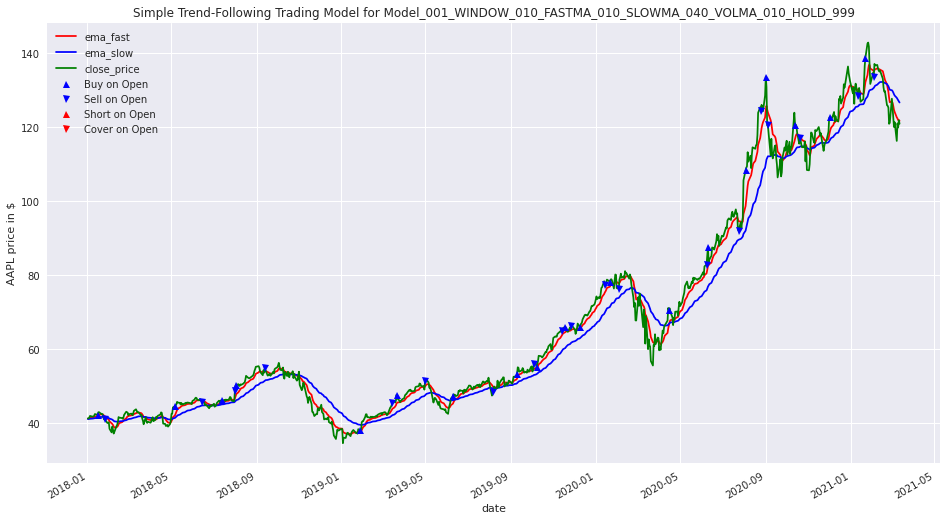

In [24]:
draw_model_graph(trading_model_collection[top_model_name], top_model_name)

In [25]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:24.514397
